# Q1 - Enunciado

O padrão a seguir foi impresso numa folha. Alguém segurou este padrão em frente ao computador com a folha paralela à tela a uma distância de 1 m e obteve a imagem que está no arquivo [`q1\padrao_1m.png`](./padrao_1m.png), que também pode ser vista abaixo

**Padrão original**

<img src=./padrao.png></img>


**Imagem obtida com a câmera a $1m$ de distância**

![](./padrao_1m.png)


As distâncias presentes no padrão são as seguintes:

<img src=./medidas.png></img>


Lembre-se ainda do modelo *pinhole* de câmera: 

<img src=./pinhole.png></img>

O vídeo necessário para o trabalho se chama [padrao.mp4 e está disponível na pasta](./padrao.mp4). 

#### O que você deve fazer:

Dadas as informações fornecidas um programa que imprime a distância D entre a folha e a câmera a cada frame.

Deixe clara qual medida você está fazendo no padrão e qual a fórmula encontrada para D.

Se você realizou alguma medida manual, anote. 


#### Orientações

Execute o programa `q1/q1.py`. Este exercício **não precisa** de ROS

Você vai notar que este programa roda o vídeo ``padrao.mp4`. 


#### O que você deve fazer:


|Resultado| Conceito| 
|---|---|
| Não executa e nem explica nada | 0 |
| Explique quais valores do modelo pinhole são necessários e os calcula| 0.75|
| Segmenta cores para alcançar objetivos  | 1.5 |
| Vai um nível além das cores, por exemplos com contornos, formas e distâncias | 2.3 |
| Imprime sempre corretamente a distância D | 3.3 | 

Casos intermediários ou omissos da rubrica serão decididos pelo professor.


# Explicação da solução

In [20]:
from __future__ import print_function, division

import cv2
import numpy as np
import imlib
import os
import os.path
import matplotlib.pyplot as plt
import q1
import imutils # pip install imutils
import math
%matplotlib inline

print("Versao da Cv2 ", cv2.__version__)
import sys
print("Versao do Python", sys.version)
# print("Diretório de trabalho: ", os.getcwd()) # Descomente para verificar onde está trabalhando

Versao da Cv2  4.2.0
Versao do Python 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]


In [2]:
def multiplot(imgs, legenda):
    """ Função que plota n imagens BGR em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,5))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
        return
    for i in range(len(imgs)):
        axes[i].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
        
def multiplot_gray(imgs, legenda):
    """ Função que plota n imagens grayscale em linha"""
    fig, axes = plt.subplots(1,len(imgs), figsize=(26,5))    
    fig.suptitle(legenda)
    if len(imgs)==1: # Peculiaridade do subplot. Não é relevante para a questão
        ax = axes
        ax.imshow(cv2.cvtColor(imgs[0],  vmin=0, vmax=255, cmap="Greys_r"))
        return
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], vmin=0, vmax=255, cmap="Greys_r")

### Desenvolvimento da solução

Vamos carregar alguns frames extraídos do filme para fazermos a análise

In [3]:
names = "padrao0001.png padrao0485.png padrao0892.png padrao0005.png padrao0579.png padrao0893.png".split()
frames = [cv2.imread(os.path.join("frames",f)) for f in names]

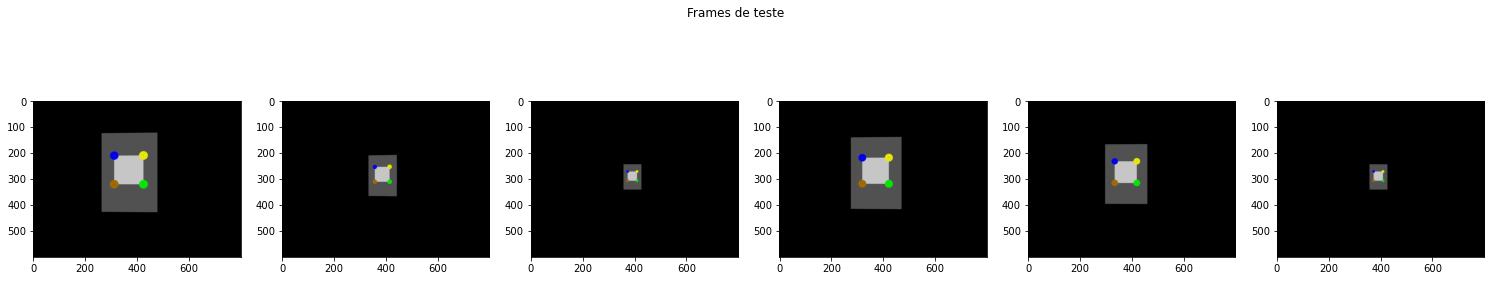

In [4]:
multiplot(frames, "Frames de teste")

### Estratégia

Devemos medir alguma distância entre os círculos coloridos presentes na folha.

Esta medição será realizada em 2 momentos:
* Manualmente na imagem `padrao_1m` obtida a $1m$ de distância, para que seja possível calcular a distância focal $f$, que nunca muda
* Através de programação, rastreando círculos coloridos a cada frame

Lembremos da relação que pode ser extraída da imagem fornecida por semelhança de triângulos:

$\frac{D}{H} = \frac{f}{h}$

As medidas $H$ e $h$ devem ser feitas em algum segmento de reta que permanece paralelo ao plano da câmera. 

Na imagem notamos que quem permanece paralelo ao plano da câmera são os segmentos azul-marrom ou amarelo-verde.


## Análise inicial

Em se tratando de um problema em que há possíveis objetos a rastrear que se constituem em cores primárias no modelo de cores RGB parece ser uma boa ideia explorar os componentes BGR num primeiro momento.

Canal B

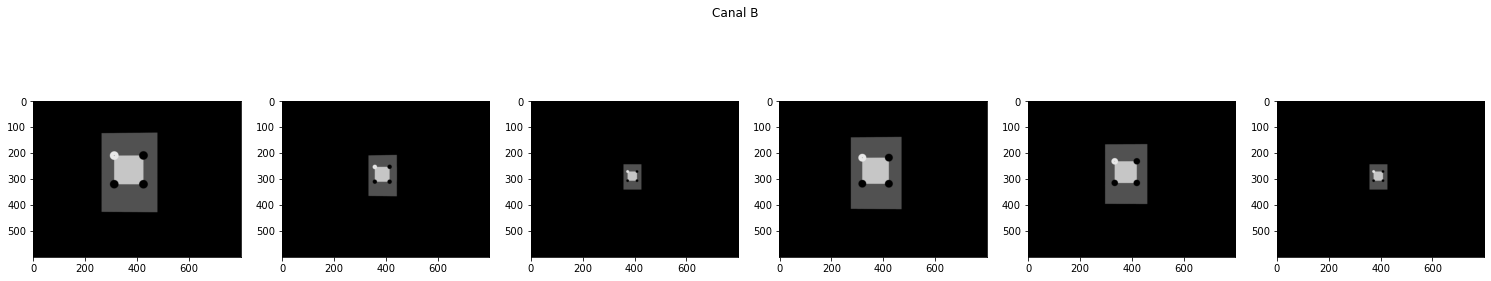

In [5]:
multiplot([f[:,:,0] for f in frames], "Canal B")

Canal G

No canal G tanto o amarelo quanto o verde têm destaque.

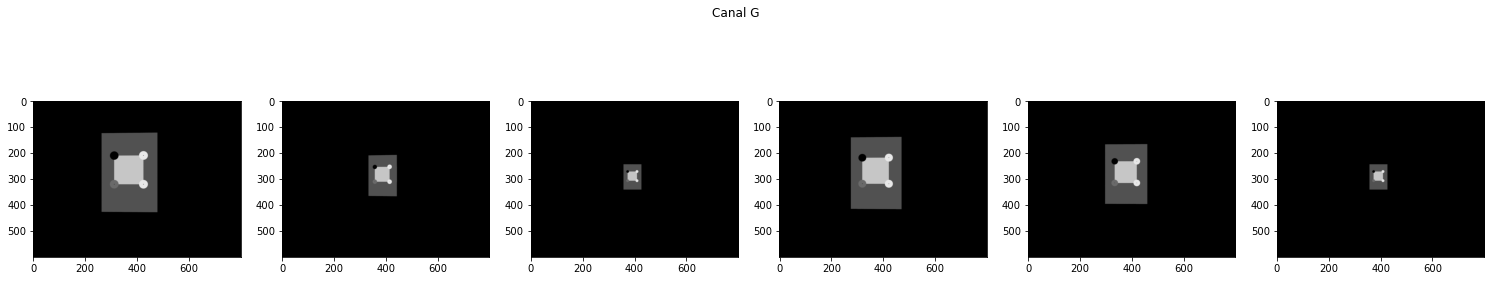

In [6]:
multiplot([f[:,:,1] for f in frames], "Canal G")

Canal R

Notamos que na imagem do canal $R$ o círculo amarelo aparece com muito mais destaque que o resto da imagem. É portanto fácil de segmentar este círculo.

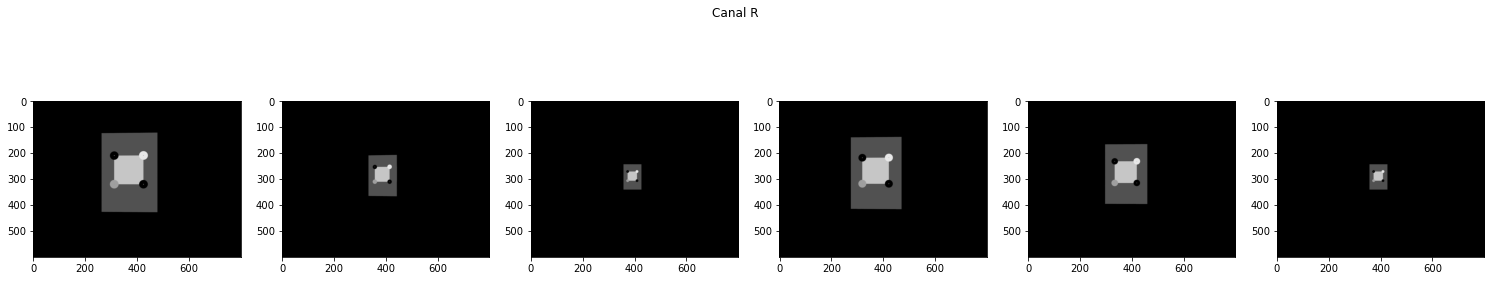

In [7]:
multiplot([f[:,:,2] for f in frames], "Canal R")

### 

### Combinações booleanas

Precisamos  de um círculo que esteja brilhante no canal G e não esteja no canal R. Basta traduzir estas lógica para uma expressão booleana.

Nota que em *Python* a operanção *AND* binária é o operador `&` e a negação binária é o operador `~`

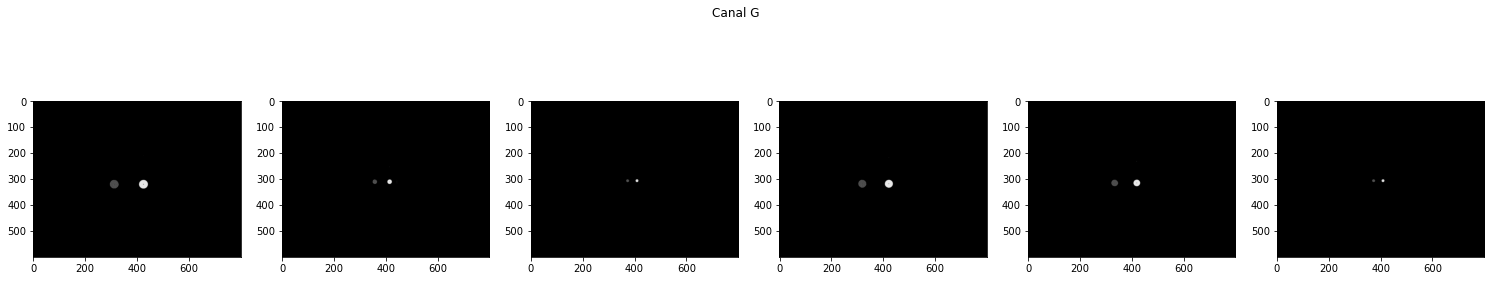

In [8]:
multiplot([f[:,:,1]&(~f[:,:,2]) for f in frames], "Canal G")

### Criação da função

In [26]:
#Fonte para escritas da opencv
font = cv2.FONT_HERSHEY_SIMPLEX    

    
def crosshair(img, point, size, color):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,2)
    cv2.line(img,(x,y - size),(x, y + size),color,2)
    
def texto(img, a, p):
    """Escreve na img RGB dada a string a na posição definida pela tupla p"""
    cv2.putText(img, str(a), p, font,1,(0,50,100),2,cv2.LINE_AA)
      

def center_of_contour(contorno):
    """ Retorna uma tupla (cx, cy) que desenha o centro do contorno"""
    M = cv2.moments(contorno)
    # Usando a expressão do centróide definida em: https://en.wikipedia.org/wiki/Image_moment
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (int(cX), int(cY))



def centro_maior_contorno(mask):
    """Retorna uma tupla com (x,y) do centro do maior contorno da imagem binária passada como entrada.
        Retorna também o contorno para plot
    """
    contornos, arvore = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maior = -1.0
    maior_c = None
    for c in contornos:            
        a = cv2.contourArea(c) # área
        if a > maior:
            p = center_of_contour(c) # centro de massa
            maior = a
            maior_c = c    
    return p,maior_c

def dist(p0, p1):
    """Retorna a distância entre duas tuplas (x,y)"""
    dx = p0[0] - p1[0]
    dy = p1[1] - p1[1]
    return math.sqrt(math.pow(dx,2) + math.pow(dy, 2))

def middle(p0, p1):
    p = p0
    t = p1
    return (int((p[0]+t[0])/2), int((p[1]+t[1])/2))
  
def processa(frame_bgr):
    """ Recebe um frame BGR e mede a distância em pixels entre os círculos verde e amarelo presentes na imagem"""    
    
    # Isolating the yellow circle
    ret, y = cv2.threshold(frame_bgr[:,:,2], 230, 255, cv2.THRESH_BINARY) # Veja https://github.com/mirwox/revisao2020
    f = frame_bgr.copy()
    
    # isolating the green circle
    g_in = f[:,:,1]&(~f[:,:,2])
    ret,g = cv2.threshold(g_in, 230, 255, cv2.THRESH_BINARY) 

    # creation of an image for display purposes
    or_img = y|g
    or_bgr = cv2.cvtColor(or_img, cv2.COLOR_GRAY2BGR)
    
    # Finding the contours
    centro_yellow,cont_yellow  = centro_maior_contorno(y)
    centro_green, cont_green = centro_maior_contorno(g)
    
    # Drawing the centers
    crosshair(or_bgr, centro_yellow, 5, (0,0,255))
    crosshair(or_bgr, centro_green, 5, (0,0,255))    
    
    # Drawing contours
    cv2.drawContours(or_bgr, [cont_yellow], -1, [0, 255, 255], 2);    
    cv2.drawContours(or_bgr, [cont_green], -1, [0, 255, 0], 2);        
    
    # Drawing labels
    font = cv2.FONT_HERSHEY_SIMPLEX    
    texto(or_bgr, "Amarelo", centro_yellow)
    texto(or_bgr, "Vermelho", centro_green)
    
    # Drawing a line between the 2 points
    cv2.line(or_bgr,centro_yellow,centro_green,(0,0,230), 1)
    
    # calculate measurements
    h = dist(centro_yellow,centro_green)
    texto(or_bgr, "h = {:2.1f}".format(h), middle(centro_yellow, centro_green))
    
    
    return or_bgr   
    

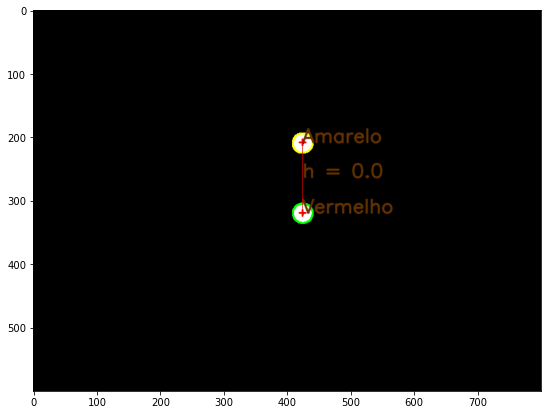

In [27]:
plt.figure(figsize=(16,7))
plt.imshow(imutils.opencv2matplotlib(processa(frames[0])))

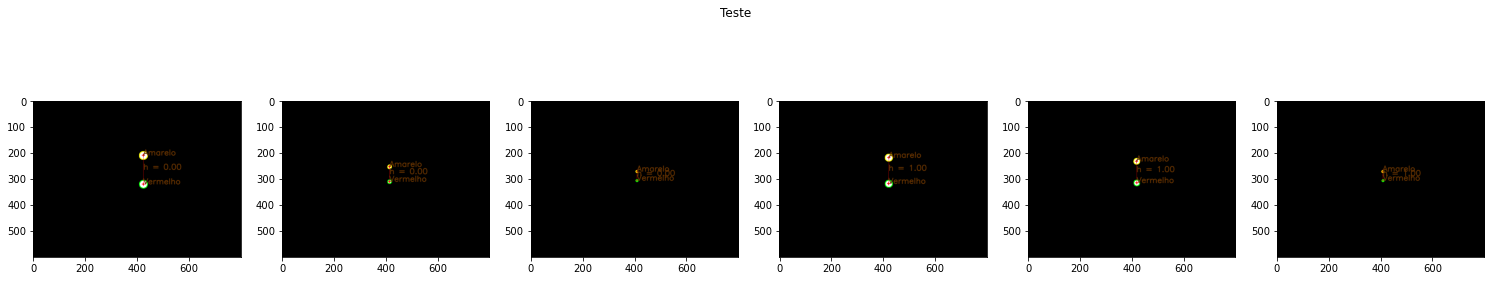

In [25]:
multiplot([processa(f) for f in frames], "Teste")